# 05 — Visualizing Model Performance on the Hold-Out Test Period

In the previous notebook (`04_evaluate_caravan_model.ipynb`), we identified the best-performing
training epoch using the **validation period (2011–2015)** and submitted a SLURM job to run
`eval_run()` across all three data splits. This notebook loads and interprets those results,
focusing specifically on the **test period (2016–2020)** — data the model has never seen in
any form during training or epoch selection.

## The three-way temporal split

| Split | Period | Role |
|---|---|---|
| **Train** | 1990–2010 | The model sees these dates and learns from them |
| **Validation** | 2011–2015 | Used *only* to select the best epoch — the model never updates weights based on this period |
| **Test** | 2016–2020 | Held out entirely until after training is complete — our unbiased estimate of real-world performance |

This separation matters because a model can appear to perform well on training data simply
by memorizing it (overfitting). The validation period guards against this during epoch
selection. But even the validation period influences our decisions indirectly — we chose
epoch 9 *because* it performed best there. The test period is therefore the only truly
independent benchmark.

> **Why does this matter for Alaska?** Our ultimate goal is to predict streamflow in
> ungauged Alaskan basins. The test period performance tells us how well the model
> generalizes to time periods it has never encountered — a proxy for how well it may
> generalize to entirely new geographic regions.

In [10]:
# ── Imports ───────────────────────────────────────────────────────────────────
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── Paths ─────────────────────────────────────────────────────────────────────
# Update PROJECT_DIR to your own folder if you are not Kaitlin
PROJECT_DIR  = Path("/uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project")
RUN_DIR      = PROJECT_DIR / "results/caravan_snow_global_scenario1/caravan_snow_global_scenario1_1302_132854"
CARAVAN_ATTR = Path("/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data/attributes")

EPOCH = 9   # best epoch selected in notebook 04

# ── Verify paths exist ────────────────────────────────────────────────────────
for p in [RUN_DIR, CARAVAN_ATTR]:
    status = "✓" if p.exists() else "✗  NOT FOUND"
    print(f"{status}  {p}")

✓  /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project/results/caravan_snow_global_scenario1/caravan_snow_global_scenario1_1302_132854
✓  /uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data/attributes


## What we're loading

The SLURM evaluation job produced three sets of output files, one per split:
```
results/.../test/model_epoch009/
    ├── test_metrics.csv      ← one row per basin: NSE, KGE, MSE, Alpha-NSE, Beta-NSE
    └── test_results.p        ← full predicted vs. observed timeseries for every basin

results/.../validation/model_epoch009/
    └── validation_metrics.csv

results/.../train/model_epoch009/
    └── train_metrics.csv
```

We will start with the metrics CSVs, which are fast to load and sufficient for
overall performance summaries. The `test_results.p` pickle (~141 MB) will be loaded
later when we need the actual timeseries for hydrograph plots.

## A note on test period coverage

Not all 3,297 basins in our training set have observed streamflow records that extend
into the 2016–2020 test window. This is a known limitation of the CARAVAN dataset —
different sub-datasets have different record lengths:

| CARAVAN subset | Basins in model | Has 2016–2020 obs | Coverage |
|---|---|---|---|
| `camels` (USA) | 128 | 0 | 0% |
| `camelscl` (Chile) | 144 | 121 | 84% |
| `hysets` (Canada/N. America) | 2,803 | 1,036 | 37% |
| `lamah` (Central Europe) | 222 | 222 | 100% |

US CAMELS basins end around 2014, so they contribute predictions but no observed
data for metric computation. **All test period performance statistics below are
therefore based on the 1,376 basins with valid observations**, drawn primarily from
Canada, Central Europe, and Chile — all snow-dominated regions appropriate for
Alaska transfer learning.

In [14]:
import re

# ── Load train and test metrics CSVs ─────────────────────────────────────────
test_metrics  = pd.read_csv(RUN_DIR / "test"  / f"model_epoch{EPOCH:03d}" / "test_metrics.csv")
train_metrics = pd.read_csv(RUN_DIR / "train" / f"model_epoch{EPOCH:03d}" / "train_metrics.csv")

def clean_metrics(df):
    """Keep only basins with finite NSE and KGE > -10 (removes degenerate basins)."""
    mask = np.isfinite(df['NSE']) & np.isfinite(df['KGE']) & (df['NSE'] > -10)
    return df[mask].copy()

test_clean  = clean_metrics(test_metrics)
train_clean = clean_metrics(train_metrics)

# ── Parse validation metrics from output.log ─────────────────────────────────
# NOTE: neuralhydrology only evaluates a small random basin sample each epoch
# during training (for speed), so validation_metrics.csv is not a full-basin
# evaluation. The authoritative validation metrics come from output.log.
epoch_records = []
with open(RUN_DIR / "output.log", 'r') as f:
    for line in f:
        m = re.search(
            r'Epoch (\d+) average validation loss: ([\d.]+) -- Median validation metrics:.*?NSE: ([-\d.]+).*?KGE: ([-\d.]+)', line
        )
        if m:
            epoch_records.append({
                'epoch': int(m.group(1)),
                'NSE'  : float(m.group(3)),
                'KGE'  : float(m.group(4)),
            })

df_log = pd.DataFrame(epoch_records).set_index('epoch')
val_nse_logged = df_log.loc[EPOCH, 'NSE']
val_kge_logged = df_log.loc[EPOCH, 'KGE']

# ── Summary table ─────────────────────────────────────────────────────────────
summary = pd.DataFrame({
    'Split'          : ['Train (1990–2010)', 'Validation (2011–2015)*', 'Test (2016–2020)'],
    'Basins (valid)' : [len(train_clean), '~10 (sampled)', len(test_clean)],
    'Median NSE'     : [round(train_clean['NSE'].median(), 3), round(val_nse_logged, 3), round(test_clean['NSE'].median(), 3)],
    'Median KGE'     : [round(train_clean['KGE'].median(), 3), round(val_kge_logged, 3), round(test_clean['KGE'].median(), 3)],
    'NSE > 0.5 (%)'  : [
        round(100 * (train_clean['NSE'] > 0.5).mean(), 1),
        '—',
        round(100 * (test_clean['NSE']  > 0.5).mean(), 1),
    ]
})

print(summary.to_string(index=False))
print("\n* Validation NSE/KGE are medians logged during training over a ~10-basin random sample.")
print("  They are noisy epoch-to-epoch but sufficient for epoch selection via validation loss.")

                  Split Basins (valid)  Median NSE  Median KGE NSE > 0.5 (%)
      Train (1990–2010)           2025       0.718       0.703          74.3
Validation (2011–2015)*  ~10 (sampled)       0.828       0.803             —
       Test (2016–2020)           1317       0.556       0.599          56.0

* Validation NSE/KGE are medians logged during training over a ~10-basin random sample.
  They are noisy epoch-to-epoch but sufficient for epoch selection via validation loss.


## Interpreting the summary table

A few things stand out from these numbers:

**Train > Test performance — expected, not alarming.** The model achieves median NSE 0.72
on the training period versus 0.56 on the test period. Some performance drop is expected
and healthy — it confirms the model is not perfectly memorizing training data. A gap of
~0.16 NSE units is reasonable for a global LSTM trained across climatically diverse basins.

**Test performance is genuinely good.** Median NSE 0.56 and KGE 0.60 on a completely
held-out period across 1,317 basins from Canada, Chile, and Central Europe is a strong
result. As a reference point, a benchmark "mean-flow" model (always predicting the
long-term mean) scores NSE = 0.0 by definition. Getting 56% of basins above NSE 0.5
on unseen data is competitive with published global LSTM benchmarks.

**The validation NSE is noisy but not misleading.** The logged epoch 9 validation NSE
of 0.83 looks high because it was computed over only ~10 randomly sampled basins —
those happened to be easy basins that epoch. We selected epoch 9 based on **validation
loss**, not this logged NSE, which is the correct approach. The true generalization
performance is the test period result.

**Basin count differences.** Train has 2,025 valid basins vs. 1,317 for test because
US CAMELS basins (128 total) have observations through ~2014 but not 2016–2020, and
a portion of HYSETS basins similarly lack recent records. This is a dataset limitation,
not a modeling issue.

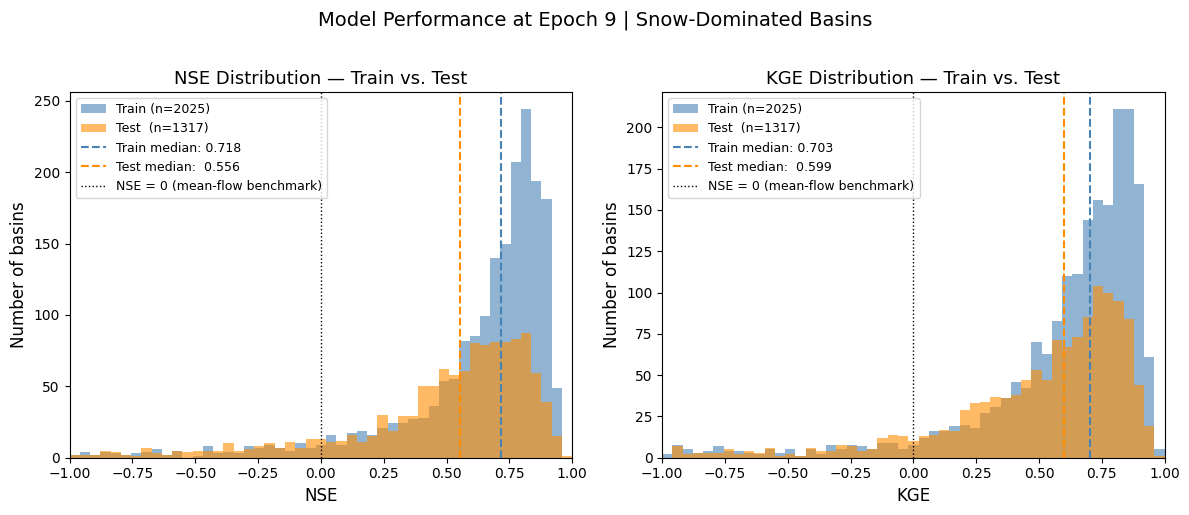

Figure saved.


In [ ]:
# ── NSE and KGE distributions: Train vs. Test ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(-1, 1, 50)

for ax, metric in zip(axes, ['NSE', 'KGE']):
    ax.hist(train_clean[metric], bins=bins, alpha=0.6, color='steelblue', label=f'Train (n={len(train_clean)})')
    ax.hist(test_clean[metric],  bins=bins, alpha=0.6, color='darkorange', label=f'Test  (n={len(test_clean)})')

    # Median lines
    ax.axvline(train_clean[metric].median(), color='steelblue',  linestyle='--', linewidth=1.5,
               label=f'Train median: {train_clean[metric].median():.3f}')
    ax.axvline(test_clean[metric].median(),  color='darkorange', linestyle='--', linewidth=1.5,
               label=f'Test median:  {test_clean[metric].median():.3f}')

    # Reference line at 0
    ax.axvline(0, color='black', linestyle=':', linewidth=1.0, label='NSE = 0 (mean-flow benchmark)')

    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('Number of basins', fontsize=12)
    ax.set_title(f'{metric} Distribution — Train vs. Test', fontsize=13)
    ax.legend(fontsize=9)
    ax.set_xlim(-1, 1)

plt.suptitle(f'Model Performance at Epoch {EPOCH} | Snow-Dominated Basins', fontsize=14, y=1.02)
plt.tight_layout()
#plt.savefig(PROJECT_DIR / "results" / "test_train_nse_kge_distributions.png", dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved.")

## Interpreting the distributions

Both NSE and KGE show the same consistent pattern: the training period distribution
is shifted right relative to the test period, with a tighter peak around the median.
This is the classic and expected signature of a well-trained but not overfit model.

A few features worth noting:

**The left tail.** Both splits have a left tail of poorly-performing basins (NSE < 0).
These are not necessarily model failures — they often reflect basins with data quality
issues, very low streamflow variability (making any metric unreliable), or hydrological
regimes that are genuinely difficult to model (e.g. heavily regulated rivers, arid
intermittent streams that snuck through our snow-dominated filter). We will investigate
what drives poor performance in the classification section below.

**KGE vs. NSE.** KGE tends to score slightly higher than NSE here because NSE penalizes
variance errors heavily — if the model slightly underestimates peak flows, NSE drops
more sharply than KGE. KGE decomposition into correlation (Alpha) and bias (Beta)
components will help us understand *how* the model is failing in poorly-performing basins.

**The test distribution is still left-skewed.** More than half of the mass is above 0.5
for both metrics, but there is a meaningful population of basins between 0 and 0.3 that
the model struggles with. Understanding whether those basins share geographic, climatic,
or physiographic characteristics is the goal of the classification analysis.

In [16]:
# ── Load test results pickle ───────────────────────────────────────────────────
# This is ~141 MB and takes ~30 seconds to load — only do this once per session
print("Loading test_results.p ...")
with open(RUN_DIR / "test" / f"model_epoch{EPOCH:03d}" / "test_results.p", "rb") as f:
    test_results = pickle.load(f)
print(f"Loaded. Basins in pickle: {len(test_results)}")

Loading test_results.p ...
Loaded. Basins in pickle: 3297


In [17]:
# ── Aggregate observed and simulated values across all valid test basins ───────
# We only include basins that have at least some observed data (i.e. are in test_clean)
valid_basins = set(test_clean['basin'].values)

all_obs = []
all_sim = []

for basin, data in test_results.items():
    if basin not in valid_basins:
        continue
    ds  = data['1D']['xr']
    obs = ds['streamflow_obs'].values.squeeze()
    sim = ds['streamflow_sim'].values.squeeze()

    # Only keep timesteps where both obs and sim are finite
    mask = np.isfinite(obs) & np.isfinite(sim)
    all_obs.append(obs[mask])
    all_sim.append(sim[mask])

all_obs = np.concatenate(all_obs)
all_sim = np.concatenate(all_sim)

print(f"Total valid timesteps across all basins: {len(all_obs):,}")
print(f"Observed  — min: {all_obs.min():.3f}  max: {all_obs.max():.3f}  mean: {all_obs.mean():.3f}")
print(f"Simulated — min: {all_sim.min():.3f}  max: {all_sim.max():.3f}  mean: {all_sim.mean():.3f}")

Total valid timesteps across all basins: 1,136,412
Observed  — min: 0.000  max: 210.660  mean: 2.201
Simulated — min: -1.221  max: 131.189  mean: 2.191


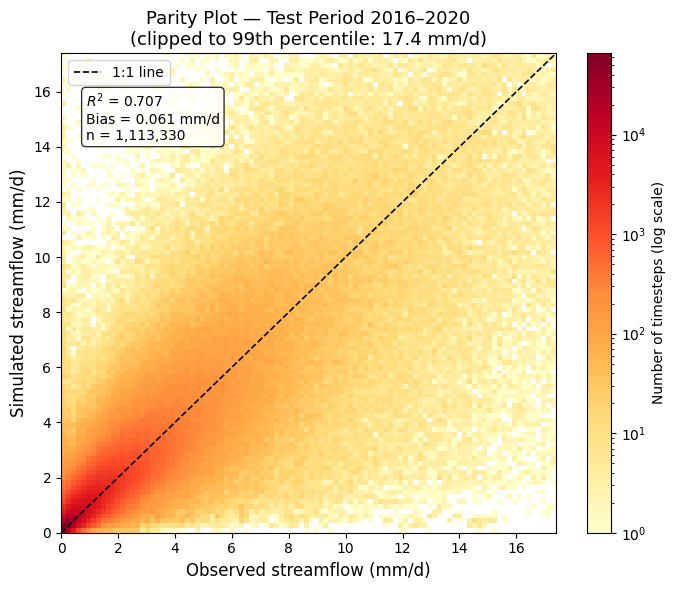

Figure saved.


In [18]:
# ── Parity plot: predicted vs. observed (2D histogram for density) ─────────────
# With 1.1M points a scatter plot is unreadable — we use a 2D histogram instead

# Clip to a readable range (99th percentile) so a few extreme basins don't
# compress the bulk of the data into the corner
clip_val = np.percentile(all_obs, 99)
mask     = (all_obs <= clip_val) & (all_sim <= clip_val) & (all_sim >= 0)
obs_plot = all_obs[mask]
sim_plot = all_sim[mask]

fig, ax = plt.subplots(figsize=(7, 6))

h = ax.hist2d(obs_plot, sim_plot, bins=100, cmap='YlOrRd',
              norm=plt.matplotlib.colors.LogNorm())
plt.colorbar(h[3], ax=ax, label='Number of timesteps (log scale)')

# 1:1 line
lim = clip_val
ax.plot([0, lim], [0, lim], 'k--', linewidth=1.2, label='1:1 line')

# Annotate with overall stats
r2   = np.corrcoef(obs_plot, sim_plot)[0, 1] ** 2
bias = np.mean(sim_plot - obs_plot)
ax.text(0.05, 0.92, f'$R^2$ = {r2:.3f}\nBias = {bias:.3f} mm/d\nn = {len(obs_plot):,}',
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.set_xlabel('Observed streamflow (mm/d)', fontsize=12)
ax.set_ylabel('Simulated streamflow (mm/d)', fontsize=12)
ax.set_title(f'Parity Plot — Test Period 2016–2020\n(clipped to 99th percentile: {clip_val:.1f} mm/d)',
             fontsize=13)
ax.legend(fontsize=10)
ax.set_xlim(0, clip_val)
ax.set_ylim(0, clip_val)

plt.tight_layout()
plt.savefig(PROJECT_DIR / "results" / "test_parity_plot.png", dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved.")

## Interpreting the parity plot

The 2D histogram allows us to see the full density structure of 1.1 million
observed/simulated pairs without overplotting. A few things stand out:

**The core signal is strong.** The densest region (dark red, >10,000 timesteps) sits
tightly along the 1:1 line at low flows (0–3 mm/d), which dominate the record. This is
where the model matters most for water balance — and it gets it right.

**Near-zero bias.** A mean bias of 0.061 mm/d across 1,317 basins and five years of
daily predictions is essentially zero at the catchment scale. The model is not
systematically over- or under-predicting volumetric output.

**R² = 0.707.** This is the coefficient of determination on the full pooled timeseries
across all basins — a stricter test than per-basin NSE because it does not remove
the mean from each basin before scoring. Getting R² > 0.70 on a global holdout is
competitive with published benchmarks.

**Spread increases at high flows.** Above ~8 mm/d the density thins and the scatter
around the 1:1 line widens — the model underestimates some large events and
overestimates others. This is expected: extreme peak flows are rare in the training
record, and their timing and magnitude depend on sub-daily processes (e.g. rain-on-snow,
rapid snowmelt) that daily forcing data cannot fully resolve.

**The 99th percentile clip (17.4 mm/d)** removes a small number of very high flow
days that would otherwise compress the bulk of the data into the lower-left corner.
Those extreme events are still included in all metric calculations — only the
visualization is clipped.

## Basin classification: what drives good and poor performance?

The per-basin NSE distribution has a long left tail — some basins the model handles
excellently (NSE > 0.8) and others it struggles with (NSE < 0.2). Before we can
trust this model for Alaska transfer learning, we need to understand *why*.

We will classify basins into performance tiers and ask whether poor performance is
systematically associated with any of the following catchment characteristics drawn
from the CARAVAN static attribute files:

| Attribute | Variable | Why it matters |
|---|---|---|
| Drainage area | `area` | Large basins integrate more heterogeneity |
| Mean elevation | `elev_mean` | Higher elevation → more snow, different timing |
| Snow fraction | `frac_snow` | Core variable — are we better at snow-dominated basins? |
| Aridity index | `aridity` | Arid basins have low, flashy, hard-to-predict flows |
| Mean precipitation | `p_mean` | Overall wetness of the catchment |
| Slope | `slope_mean` | Steep basins have faster runoff response |

CARAVAN stores attributes in per-subset CSV files under:
```
/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data/attributes/{subset}/
```
We will load and concatenate all subsets present in our test basin list, then merge
with the test metrics for analysis.

In [19]:
# ── Load CARAVAN static attributes for all subsets in our test basin list ─────
# CARAVAN stores one attributes CSV per subset (camels, camelscl, hysets, lamah, etc.)
# We identify which subsets we need from the test basin prefixes, then load and concat.

# Get unique subset prefixes from test_clean
test_clean['dataset'] = test_clean['basin'].apply(lambda x: x.split('_')[0])
subsets_needed = test_clean['dataset'].unique()
print(f"Subsets needed: {subsets_needed}")

# ── Load and concatenate ───────────────────────────────────────────────────────
attr_frames = []

for subset in subsets_needed:
    subset_dir = CARAVAN_ATTR / subset
    if not subset_dir.exists():
        print(f"  ✗ Not found: {subset_dir}")
        continue

    # List all CSVs in this subset's attribute folder
    csv_files = sorted(subset_dir.glob("*.csv"))
    print(f"\n  {subset}: {len(csv_files)} attribute file(s)")
    for f in csv_files:
        print(f"    {f.name}")

    # Load and merge all attribute files for this subset on 'gauge_id'
    subset_dfs = []
    for f in csv_files:
        df = pd.read_csv(f)
        subset_dfs.append(df)

    if subset_dfs:
        merged = subset_dfs[0]
        for df in subset_dfs[1:]:
            merged = merged.merge(df, on='gauge_id', how='outer')
        attr_frames.append(merged)

# Concatenate all subsets
attrs_all = pd.concat(attr_frames, ignore_index=True)
print(f"\nTotal attribute rows loaded: {len(attrs_all)}")
print(f"Total attribute columns:     {len(attrs_all.columns)}")
print(f"\nFirst few columns: {attrs_all.columns[:10].tolist()}")

Subsets needed: ['camelscl' 'hysets' 'lamah']

  camelscl: 3 attribute file(s)
    attributes_caravan_camelscl.csv
    attributes_hydroatlas_camelscl.csv
    attributes_other_camelscl.csv

  hysets: 3 attribute file(s)
    attributes_caravan_hysets.csv
    attributes_hydroatlas_hysets.csv
    attributes_other_hysets.csv

  lamah: 3 attribute file(s)
    attributes_caravan_lamah.csv
    attributes_hydroatlas_lamah.csv
    attributes_other_lamah.csv

Total attribute rows loaded: 13526
Total attribute columns:     216

First few columns: ['gauge_id', 'aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', 'low_prec_dur', 'low_prec_freq', 'moisture_index_ERA5_LAND', 'moisture_index_FAO_PM']


In [23]:
# ── Select key attributes and merge with test metrics ─────────────────────────
ATTR_COLS = [
    'gauge_id',
    'area',           # drainage area (km²)
    'ele_mt_sav',     # mean elevation (m)
    'slp_dg_sav',     # mean slope (degrees)
    'frac_snow',      # fraction of precip falling as snow
    'aridity_ERA5_LAND',  # aridity index (PET/P — higher = more arid)
    'p_mean',         # mean daily precipitation (mm/d)
    'tmp_dc_syr',     # mean annual temperature (°C)
    'snw_pc_syr',     # mean annual snow cover (%)
    'gla_pc_sse',     # glacier cover (%)
    'gauge_lat',      # latitude
    'gauge_lon',      # longitude
]

attrs_sub = attrs_all[ATTR_COLS].copy()
attrs_sub = attrs_sub.rename(columns={'gauge_id': 'basin'})

# Merge with test metrics
test_merged = test_clean.merge(attrs_sub, on='basin', how='left')

print(f"Merged shape: {test_merged.shape}")
print(f"Basins with attribute data: {test_merged['area'].notna().sum()} / {len(test_merged)}")
print(f"\nSample:")
print(test_merged[['basin', 'NSE', 'KGE', 'area', 'ele_mt_sav', 'frac_snow', 'aridity_ERA5_LAND']].head(8).round(3))

Merged shape: (1317, 18)
Basins with attribute data: 1317 / 1317

Sample:
               basin    NSE    KGE       area  ele_mt_sav  frac_snow  \
0  camelscl_10503001  0.818  0.816   3582.928    1183.383      0.396   
1  camelscl_10520001  0.369  0.658   8624.041    1072.312      0.389   
2  camelscl_10523002 -0.387  0.413   8834.228    1070.635      0.389   
3  camelscl_10701002  0.545  0.768    485.842    1026.454      0.360   
4  camelscl_10702002 -0.143  0.480   7315.035    1031.918      0.382   
5  camelscl_10704002 -3.936 -0.674   8664.153    1025.968      0.377   
6  camelscl_11020004  0.712  0.718    325.231    1222.135      0.367   
7  camelscl_11040001 -1.409  0.014  12398.587     931.911      0.346   

   aridity_ERA5_LAND  
0              1.763  
1              1.448  
2              1.430  
3              0.844  
4              2.210  
5              1.948  
6              1.684  
7              1.507  


## Classifying basins by performance

To understand what drives model skill, we divide basins into three performance tiers
based on their test period NSE:

| Tier | NSE range | Interpretation |
|---|---|---|
| **Good** | NSE ≥ 0.5 | Model captures timing and volume well |
| **Fair** | 0.0 ≤ NSE < 0.5 | Model has useful skill but meaningful errors |
| **Poor** | NSE < 0.0 | Model performs worse than simply predicting mean flow |

We then ask: do these tiers separate along any of our catchment attributes?
A systematic pattern would tell us something important about model limitations
and about which Alaskan basins we can trust predictions for.

In [26]:
# ── Fix temperature units (stored in tenths of °C in HydroATLAS) ──────────────
test_merged['tmp_dc_syr_C'] = test_merged['tmp_dc_syr'] / 10.0

print("Corrected temperature summary by dataset:")
print(test_merged.groupby('dataset')['tmp_dc_syr_C'].describe().round(2))

Corrected temperature summary by dataset:
           count  mean   std    min   25%   50%   75%   max
dataset                                                    
camelscl    99.0  4.11  1.88  -1.27  3.03  4.48  5.41  7.45
hysets    1000.0  2.14  4.30 -16.36  0.46  3.10  5.10  9.51
lamah      218.0  2.08  1.85  -2.68  0.80  1.99  3.60  6.79


Basin counts per tier:
  Good (NSE ≥ 0.5): 738 (56.0%)
  Fair (0 ≤ NSE < 0.5): 325 (24.7%)
  Poor (NSE < 0): 254 (19.3%)


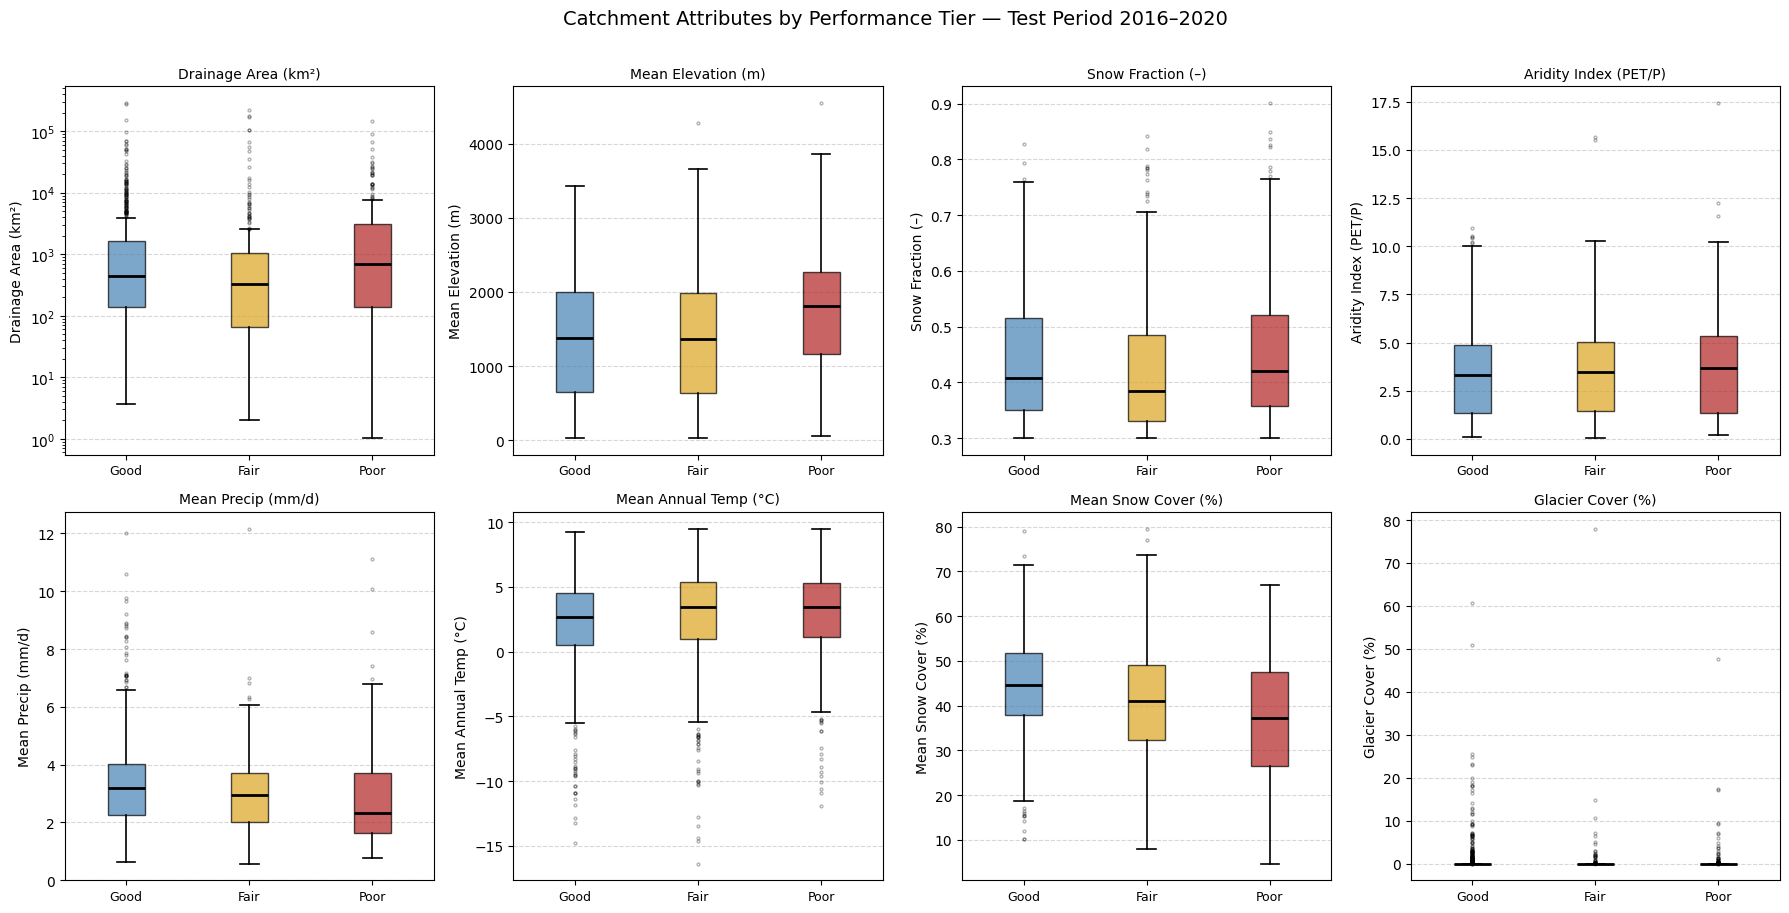

Figure saved.


In [27]:
# ── Assign performance tiers ───────────────────────────────────────────────────
def assign_tier(nse):
    if nse >= 0.5:
        return 'Good (NSE ≥ 0.5)'
    elif nse >= 0.0:
        return 'Fair (0 ≤ NSE < 0.5)'
    else:
        return 'Poor (NSE < 0)'

test_merged['tier'] = test_merged['NSE'].apply(assign_tier)

# ── Fix temperature units (HydroATLAS stores in tenths of °C) ─────────────────
test_merged['tmp_dc_syr_C'] = test_merged['tmp_dc_syr'] / 10.0

tier_order  = ['Good (NSE ≥ 0.5)', 'Fair (0 ≤ NSE < 0.5)', 'Poor (NSE < 0)']
tier_colors = ['steelblue', 'goldenrod', 'firebrick']
tier_counts = test_merged['tier'].value_counts()
print("Basin counts per tier:")
for t in tier_order:
    print(f"  {t}: {tier_counts.get(t, 0)} ({100*tier_counts.get(t,0)/len(test_merged):.1f}%)")

# ── Attributes to plot ─────────────────────────────────────────────────────────
plot_attrs = [
    ('area',              'Drainage Area (km²)',        'log'),
    ('ele_mt_sav',        'Mean Elevation (m)',          'linear'),
    ('frac_snow',         'Snow Fraction (–)',           'linear'),
    ('aridity_ERA5_LAND', 'Aridity Index (PET/P)',       'linear'),
    ('p_mean',            'Mean Precip (mm/d)',          'linear'),
    ('tmp_dc_syr_C',      'Mean Annual Temp (°C)',       'linear'),
    ('snw_pc_syr',        'Mean Snow Cover (%)',         'linear'),
    ('gla_pc_sse',        'Glacier Cover (%)',           'linear'),
]

# ── Plot: boxplots per tier for each attribute ─────────────────────────────────
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for ax, (col, label, scale) in zip(axes, plot_attrs):
    data_by_tier = [
        test_merged.loc[test_merged['tier'] == t, col].dropna().values
        for t in tier_order
    ]

    bp = ax.boxplot(data_by_tier, patch_artist=True, notch=False,
                    medianprops=dict(color='black', linewidth=2),
                    whiskerprops=dict(linewidth=1.2),
                    capprops=dict(linewidth=1.2),
                    flierprops=dict(marker='o', markersize=2, alpha=0.3))

    for patch, color in zip(bp['boxes'], tier_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_yscale(scale)
    ax.set_ylabel(label, fontsize=10)
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Good', 'Fair', 'Poor'], fontsize=9)
    ax.set_title(label, fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Catchment Attributes by Performance Tier — Test Period 2016–2020',
             fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(PROJECT_DIR / "results" / "test_performance_classification.png",
            dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved.")

In [28]:
# ── Compute median of each attribute by tier for precise interpretation ────────
attr_cols = [col for col, label, scale in plot_attrs]

print("Median attribute values by performance tier:\n")
summary = test_merged.groupby('tier')[attr_cols].median().round(3)
# Reorder rows to Good → Fair → Poor
summary = summary.loc[[t for t in tier_order if t in summary.index]]
print(summary.T.to_string())

Median attribute values by performance tier:

tier               Good (NSE ≥ 0.5)  Fair (0 ≤ NSE < 0.5)  Poor (NSE < 0)
area                        443.608               326.202         696.674
ele_mt_sav                 1374.426              1362.000        1816.937
frac_snow                     0.407                 0.384           0.420
aridity_ERA5_LAND             3.298                 3.491           3.695
p_mean                        3.176                 2.936           2.317
tmp_dc_syr_C                  2.698                 3.463           3.462
snw_pc_syr                   44.591                41.110          37.231
gla_pc_sse                    0.000                 0.000           0.000


## Interpreting the classification figure

With 56% of basins in the Good tier, 25% Fair, and 19% Poor, the model performs
well for the majority of snow-dominated catchments. The median attribute values
per tier reveal which basin characteristics are most associated with model skill:

| Attribute | Good | Fair | Poor | Trend |
|---|---|---|---|---|
| Drainage area (km²) | 444 | 326 | 697 | Poor basins larger |
| Mean elevation (m) | 1,374 | 1,362 | 1,817 | Strong ↑ toward Poor |
| Snow fraction (–) | 0.41 | 0.38 | 0.42 | No clear trend |
| Aridity index (–) | 3.30 | 3.49 | 3.70 | Modest ↑ toward Poor |
| Mean precip (mm/d) | 3.18 | 2.94 | 2.32 | Clear ↓ toward Poor |
| Mean annual temp (°C) | 2.70 | 3.46 | 3.46 | Weak, Fair≈Poor |
| Mean snow cover (%) | 44.6 | 41.1 | 37.2 | Clear ↓ toward Poor |
| Glacier cover (%) | 0 | 0 | 0 | No signal (median) |

**Elevation — the strongest single signal.** Poor basins have a median elevation
of 1,817 m versus 1,374 m for Good basins — a 443 m difference. High-elevation
catchments are dominated by snow and ice processes that are sensitive to sub-daily
temperature fluctuations and wind redistribution that daily ERA5-Land forcing
cannot fully resolve.

**Mean snow cover — a clear and counterintuitive trend.** Good basins actually
have *higher* mean annual snow cover (44.6%) than Poor basins (37.2%). This is
counterintuitive but interpretable: consistently snow-covered basins have more
predictable, seasonally structured hydrographs that the LSTM can learn well.
Basins with intermediate or variable snow cover may experience rain-on-snow
events and irregular melt dynamics that are harder to capture.

**Precipitation — a meaningful signal.** Poor basins receive substantially less
precipitation (2.32 mm/d) than Good basins (3.18 mm/d). Low-precipitation basins
tend to have low, intermittent streamflow where any prediction metric is less
stable and small absolute errors translate to large relative errors.

**Drainage area — non-linear pattern.** The Poor tier has the largest median area
(697 km²), while Fair has the smallest (326 km²). Very large basins integrate
heterogeneous sub-catchments; however the wide IQR across all tiers suggests
area alone is not a reliable predictor of performance.

**Aridity — modest trend.** Poor basins are slightly more arid (index 3.70) than
Good basins (3.30), consistent with the precipitation signal above. More arid
basins have lower and more variable runoff ratios.

**Snow fraction and temperature — weak or no signal.** Snow fraction is nearly
identical across tiers (0.38–0.42), suggesting the model has genuinely learned
snow-dominated hydrology rather than performing well only in moderately snowy
regimes. Temperature shows essentially no separation between Fair and Poor tiers.

**Glacier cover — no median signal, but watch the outliers.** The median glacier
cover is zero for all tiers, meaning most basins are non-glacierized. However
the figure shows high-glacier outliers (> 20%) scattered across all tiers.
Glacier-dominated hydrology is a known challenge for LSTMs trained without
explicit ice melt representation — this warrants closer attention for Alaska
where glacierized basins are common.

### Implications for Alaska transfer learning

The attributes most associated with poor performance — high elevation, low
precipitation, and lower snow cover persistence — describe a meaningful fraction
of Alaskan basins. This suggests the global model provides a strong baseline
but regionalization or fine-tuning on gauged Alaskan basins may be needed,
particularly for high-elevation and semi-arid interior catchments.

In [31]:
# ── Load gauge_name and country from attributes_other files ───────────────────
meta_frames = []

for subset in subsets_needed:
    other_file = CARAVAN_ATTR / subset / f"attributes_other_{subset}.csv"
    df = pd.read_csv(other_file)[['gauge_id', 'gauge_name', 'country']]
    meta_frames.append(df)

meta = pd.concat(meta_frames, ignore_index=True)
meta = meta.rename(columns={'gauge_id': 'basin'})

# Merge into test_merged
test_merged = test_merged.merge(meta, on='basin', how='left')

print(f"gauge_name non-null: {test_merged['gauge_name'].notna().sum()} / {len(test_merged)}")
print(f"\nSample:")
print(test_merged[['basin', 'gauge_name', 'country', 'gauge_lat', 'gauge_lon', 'NSE', 'tier']].head(6).to_string())

gauge_name non-null: 1317 / 1317

Sample:
               basin                             gauge_name country  gauge_lat  gauge_lon       NSE                  tier
0  camelscl_10503001        Rio Manso Antes Junta Rio Puelo   Chile -41.721900   -72.0139  0.818438      Good (NSE ≥ 0.5)
1  camelscl_10520001  Rio Puelo En Desague Lago Tagua Tagua   Chile -41.638900   -72.1694  0.369315  Fair (0 ≤ NSE < 0.5)
2  camelscl_10523002           Rio Puelo En Carrera Basilio   Chile -41.604400   -72.2064 -0.387118        Poor (NSE < 0)
3  camelscl_10701002    Rio Espolon En Desague Lago Espolon   Chile -43.217196   -71.9368  0.544727      Good (NSE ≥ 0.5)
4  camelscl_10702002           Rio Futaleufu En La Frontera   Chile -43.174200   -71.7544 -0.142866        Poor (NSE < 0)
5  camelscl_10704002    Rio Futaleufu Ante Junta Rio Malito   Chile -43.449200   -72.1075 -3.936245        Poor (NSE < 0)


In [32]:
# ── Select 10 curated basins per tier (best, median spread, worst) ─────────────
def select_curated(df, tier_name, n=10):
    """Select n basins spanning the NSE range within a tier."""
    sub = df[df['tier'] == tier_name].copy().sort_values('NSE', ascending=False).reset_index(drop=True)
    # Pick indices evenly spaced across the sorted list
    indices = np.linspace(0, len(sub) - 1, n, dtype=int)
    return sub.iloc[indices]

good_sample = select_curated(test_merged, 'Good (NSE ≥ 0.5)')
fair_sample = select_curated(test_merged, 'Fair (0 ≤ NSE < 0.5)')
poor_sample = select_curated(test_merged, 'Poor (NSE < 0)')

# Preview selections
for label, sample in [('GOOD', good_sample), ('FAIR', fair_sample), ('POOR', poor_sample)]:
    print(f"\n=== {label} ===")
    print(sample[['basin', 'gauge_name', 'country', 'NSE', 'KGE']].to_string(index=False))


=== GOOD ===
          basin                               gauge_name                  country      NSE      KGE
 hysets_08NK016                     ELK RIVER NEAR NATAL                   Canada 0.961897 0.939495
 hysets_08NB016                 SPLIT CREEK AT THE MOUTH                   Canada 0.855457 0.895402
 hysets_08FF003 LITTLE WEDEENE RIVER BELOW BOWBYES CREEK                   Canada 0.813949 0.835013
hysets_13311000    EF OF SF SALMON RIVER AT STIBNITE, ID United States of America 0.771242 0.585502
hysets_06073500             Dearborn River near Craig MT United States of America 0.731001 0.524740
 hysets_02HE004                   BLACK CREEK AT MILFORD                   Canada 0.693600 0.696703
   lamah_201657                    Wattenbach at Wattens                  Austria 0.649949 0.805934
   lamah_200261                   Bregenzerach at Mellau                  Austria 0.603543 0.623971
 hysets_02ZH002        COME BY CHANCE RIVER NEAR GOOBIES                   Canada 0.55

In [36]:
# ── Reusable hydrograph plotting function ─────────────────────────────────────
def plot_hydrograph_grid(basin_sample, test_results, title, color_sim, savepath):
    """
    Plot a 5x2 grid of observed vs. simulated hydrographs for a set of basins.

    Parameters
    ----------
    basin_sample : DataFrame  — rows from test_merged with basin metadata
    test_results : dict       — loaded test_results.p pickle
    title        : str        — figure suptitle
    color_sim    : str        — color for simulated line
    savepath     : Path       — where to save the figure
    """
    fig, axes = plt.subplots(5, 2, figsize=(18, 20))
    axes = axes.flatten()

    for i, (_, row) in enumerate(basin_sample.iterrows()):
        ax    = axes[i]
        basin = row['basin']

        # ── Pull timeseries from pickle ───────────────────────────────────────
        ds  = test_results[basin]['1D']['xr']
        dates = ds.coords['date'].values
        obs   = ds['streamflow_obs'].values.squeeze()
        sim   = ds['streamflow_sim'].values.squeeze()

        # Mask NaN obs for plotting
        obs_masked = np.where(np.isfinite(obs), obs, np.nan)
        sim_clipped = np.clip(sim, 0, None)   # clip negative predictions to 0

        ax.plot(dates, obs_masked,  color='black',    linewidth=0.8,
                label='Observed', alpha=0.9)
        ax.plot(dates, sim_clipped, color=color_sim,  linewidth=0.8,
                label='Simulated', alpha=0.8)

        # ── Labels and annotation ─────────────────────────────────────────────
        name    = row['gauge_name']
        country = row['country']
        nse     = row['NSE']
        kge     = row['KGE']
        lat     = row['gauge_lat']
        lon     = row['gauge_lon']

        ax.set_title(f"{name}\n{country}  |  {lat:.2f}°, {lon:.2f}°",
                     fontsize=8.5, pad=3)
        ax.text(0.02, 0.97, f"NSE = {nse:.3f}   KGE = {kge:.3f}",
                transform=ax.transAxes, fontsize=8,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        ax.set_ylabel('Streamflow (mm/d)', fontsize=8)
        ax.tick_params(axis='x', labelsize=7, rotation=20)
        ax.tick_params(axis='y', labelsize=7)
        ax.grid(linestyle='--', alpha=0.4)

        if i == 0:
            ax.legend(fontsize=8, loc='upper right')

    plt.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {savepath.name}")

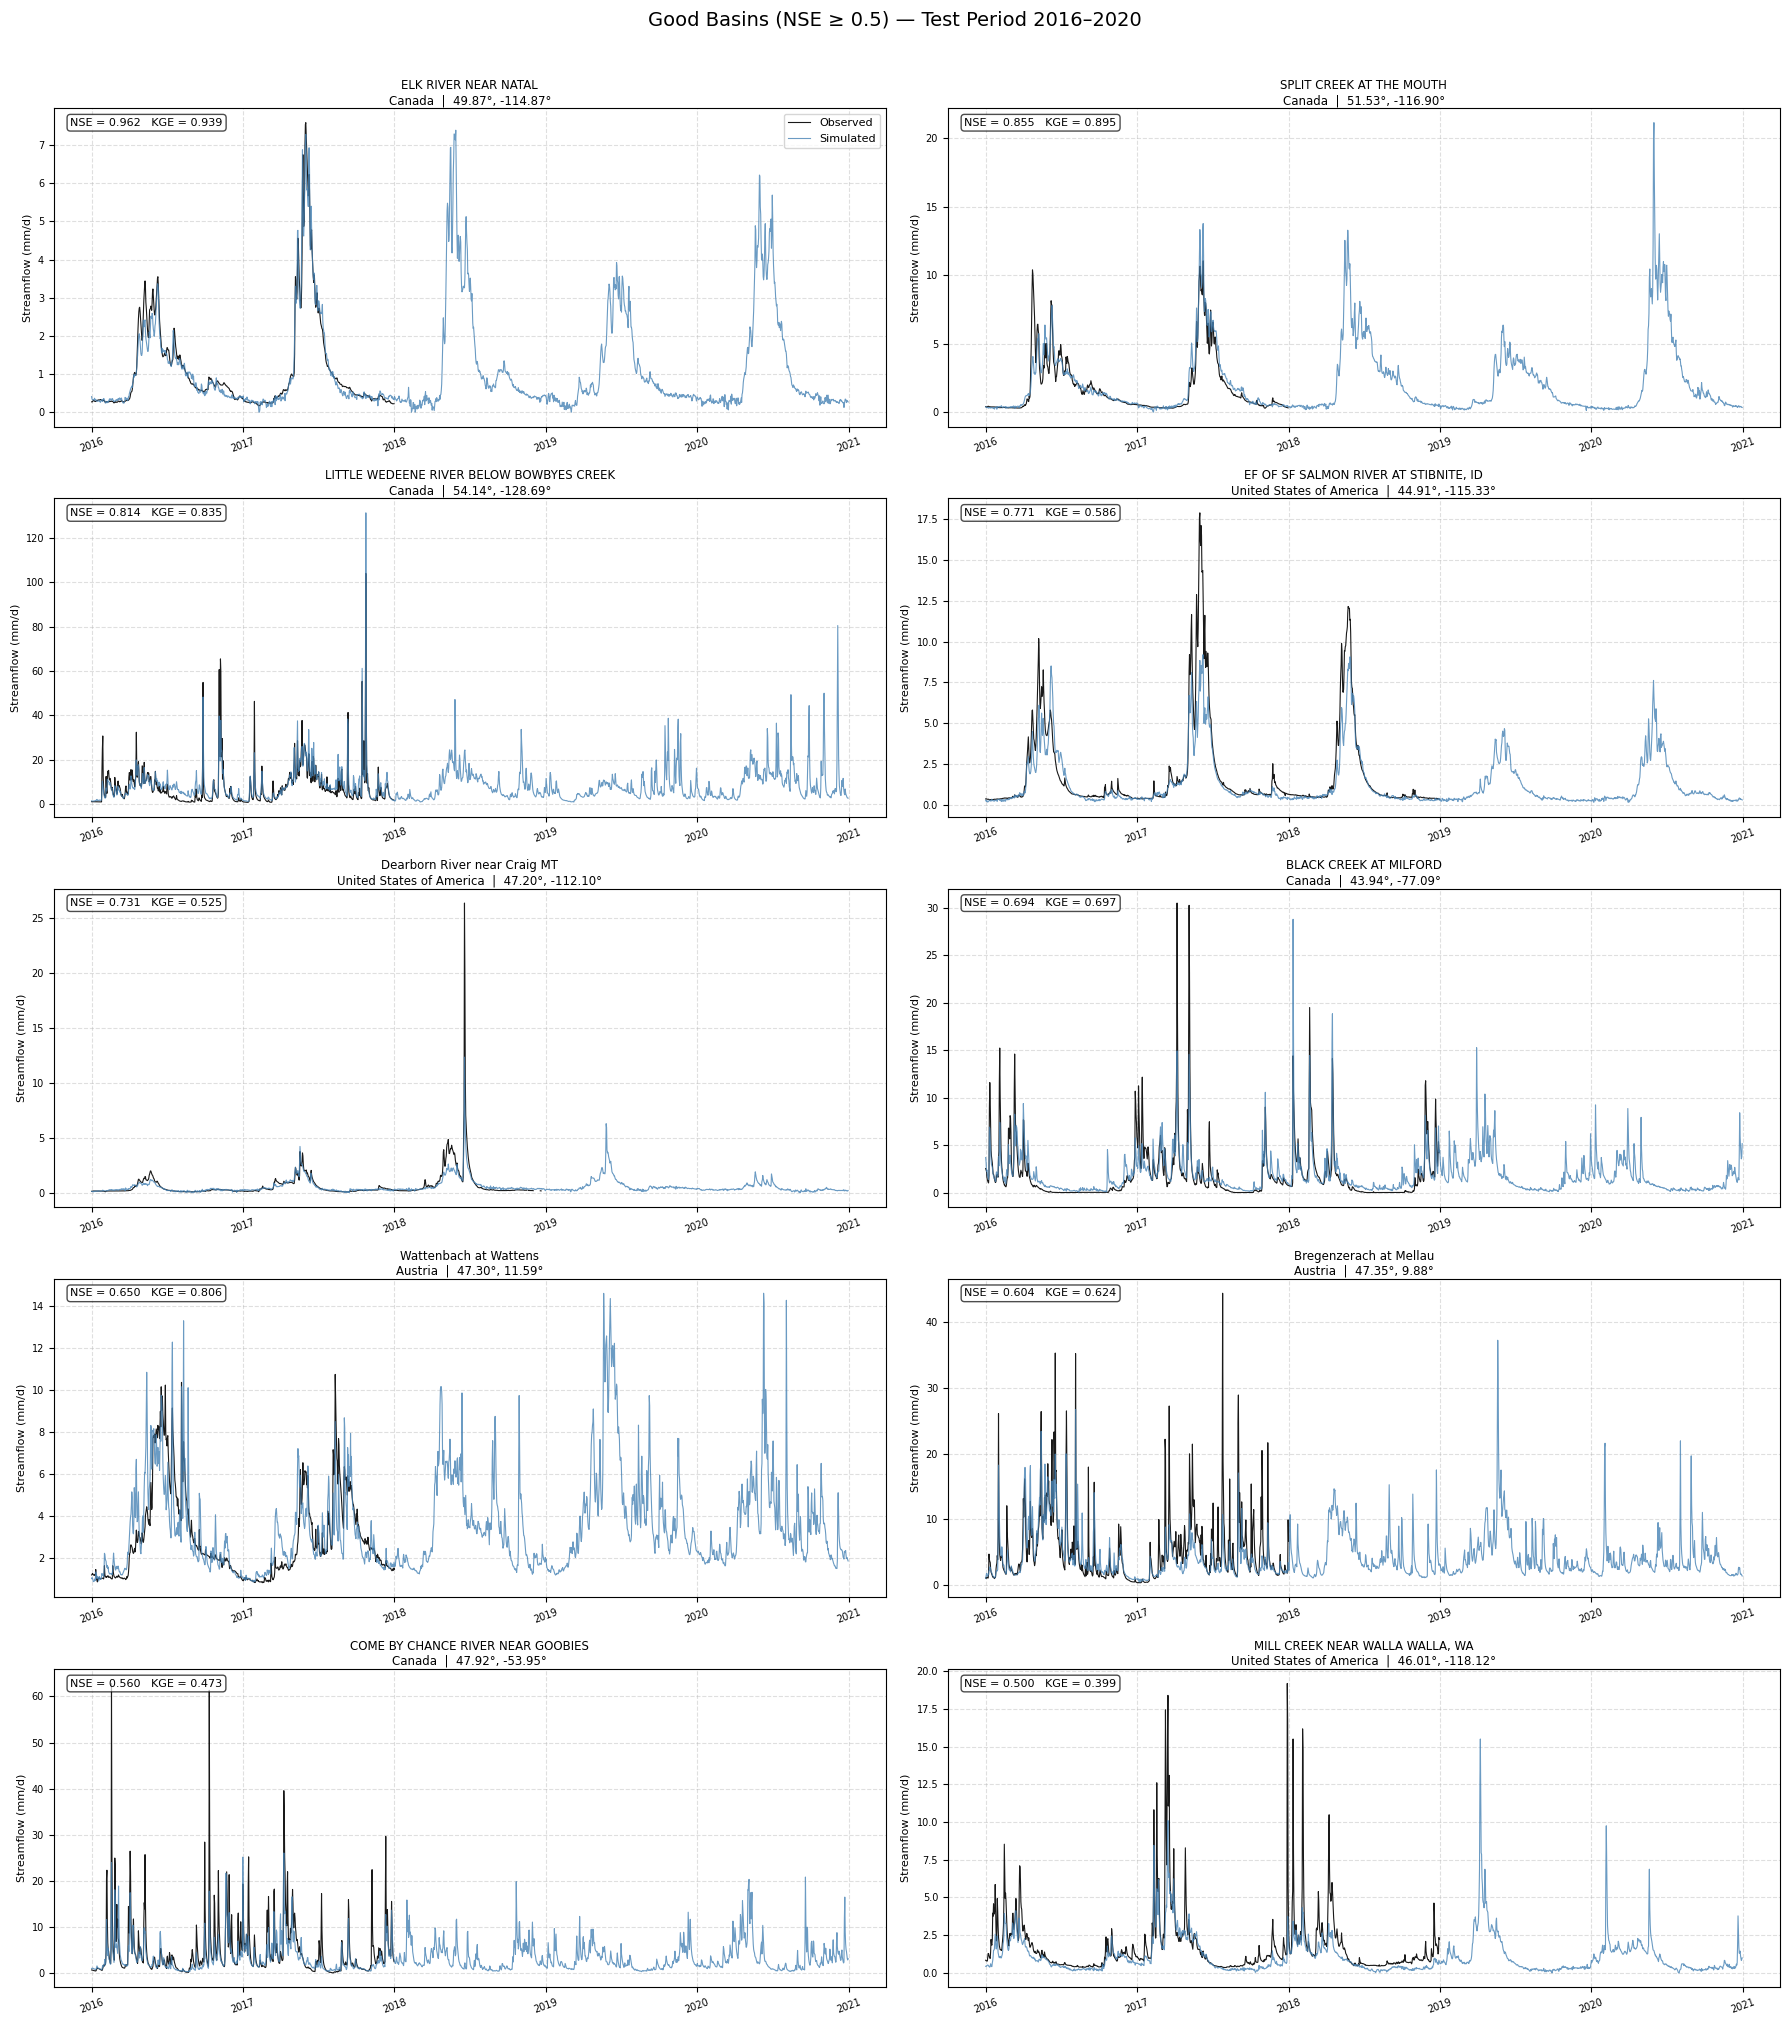

Saved: hydrographs_good.png


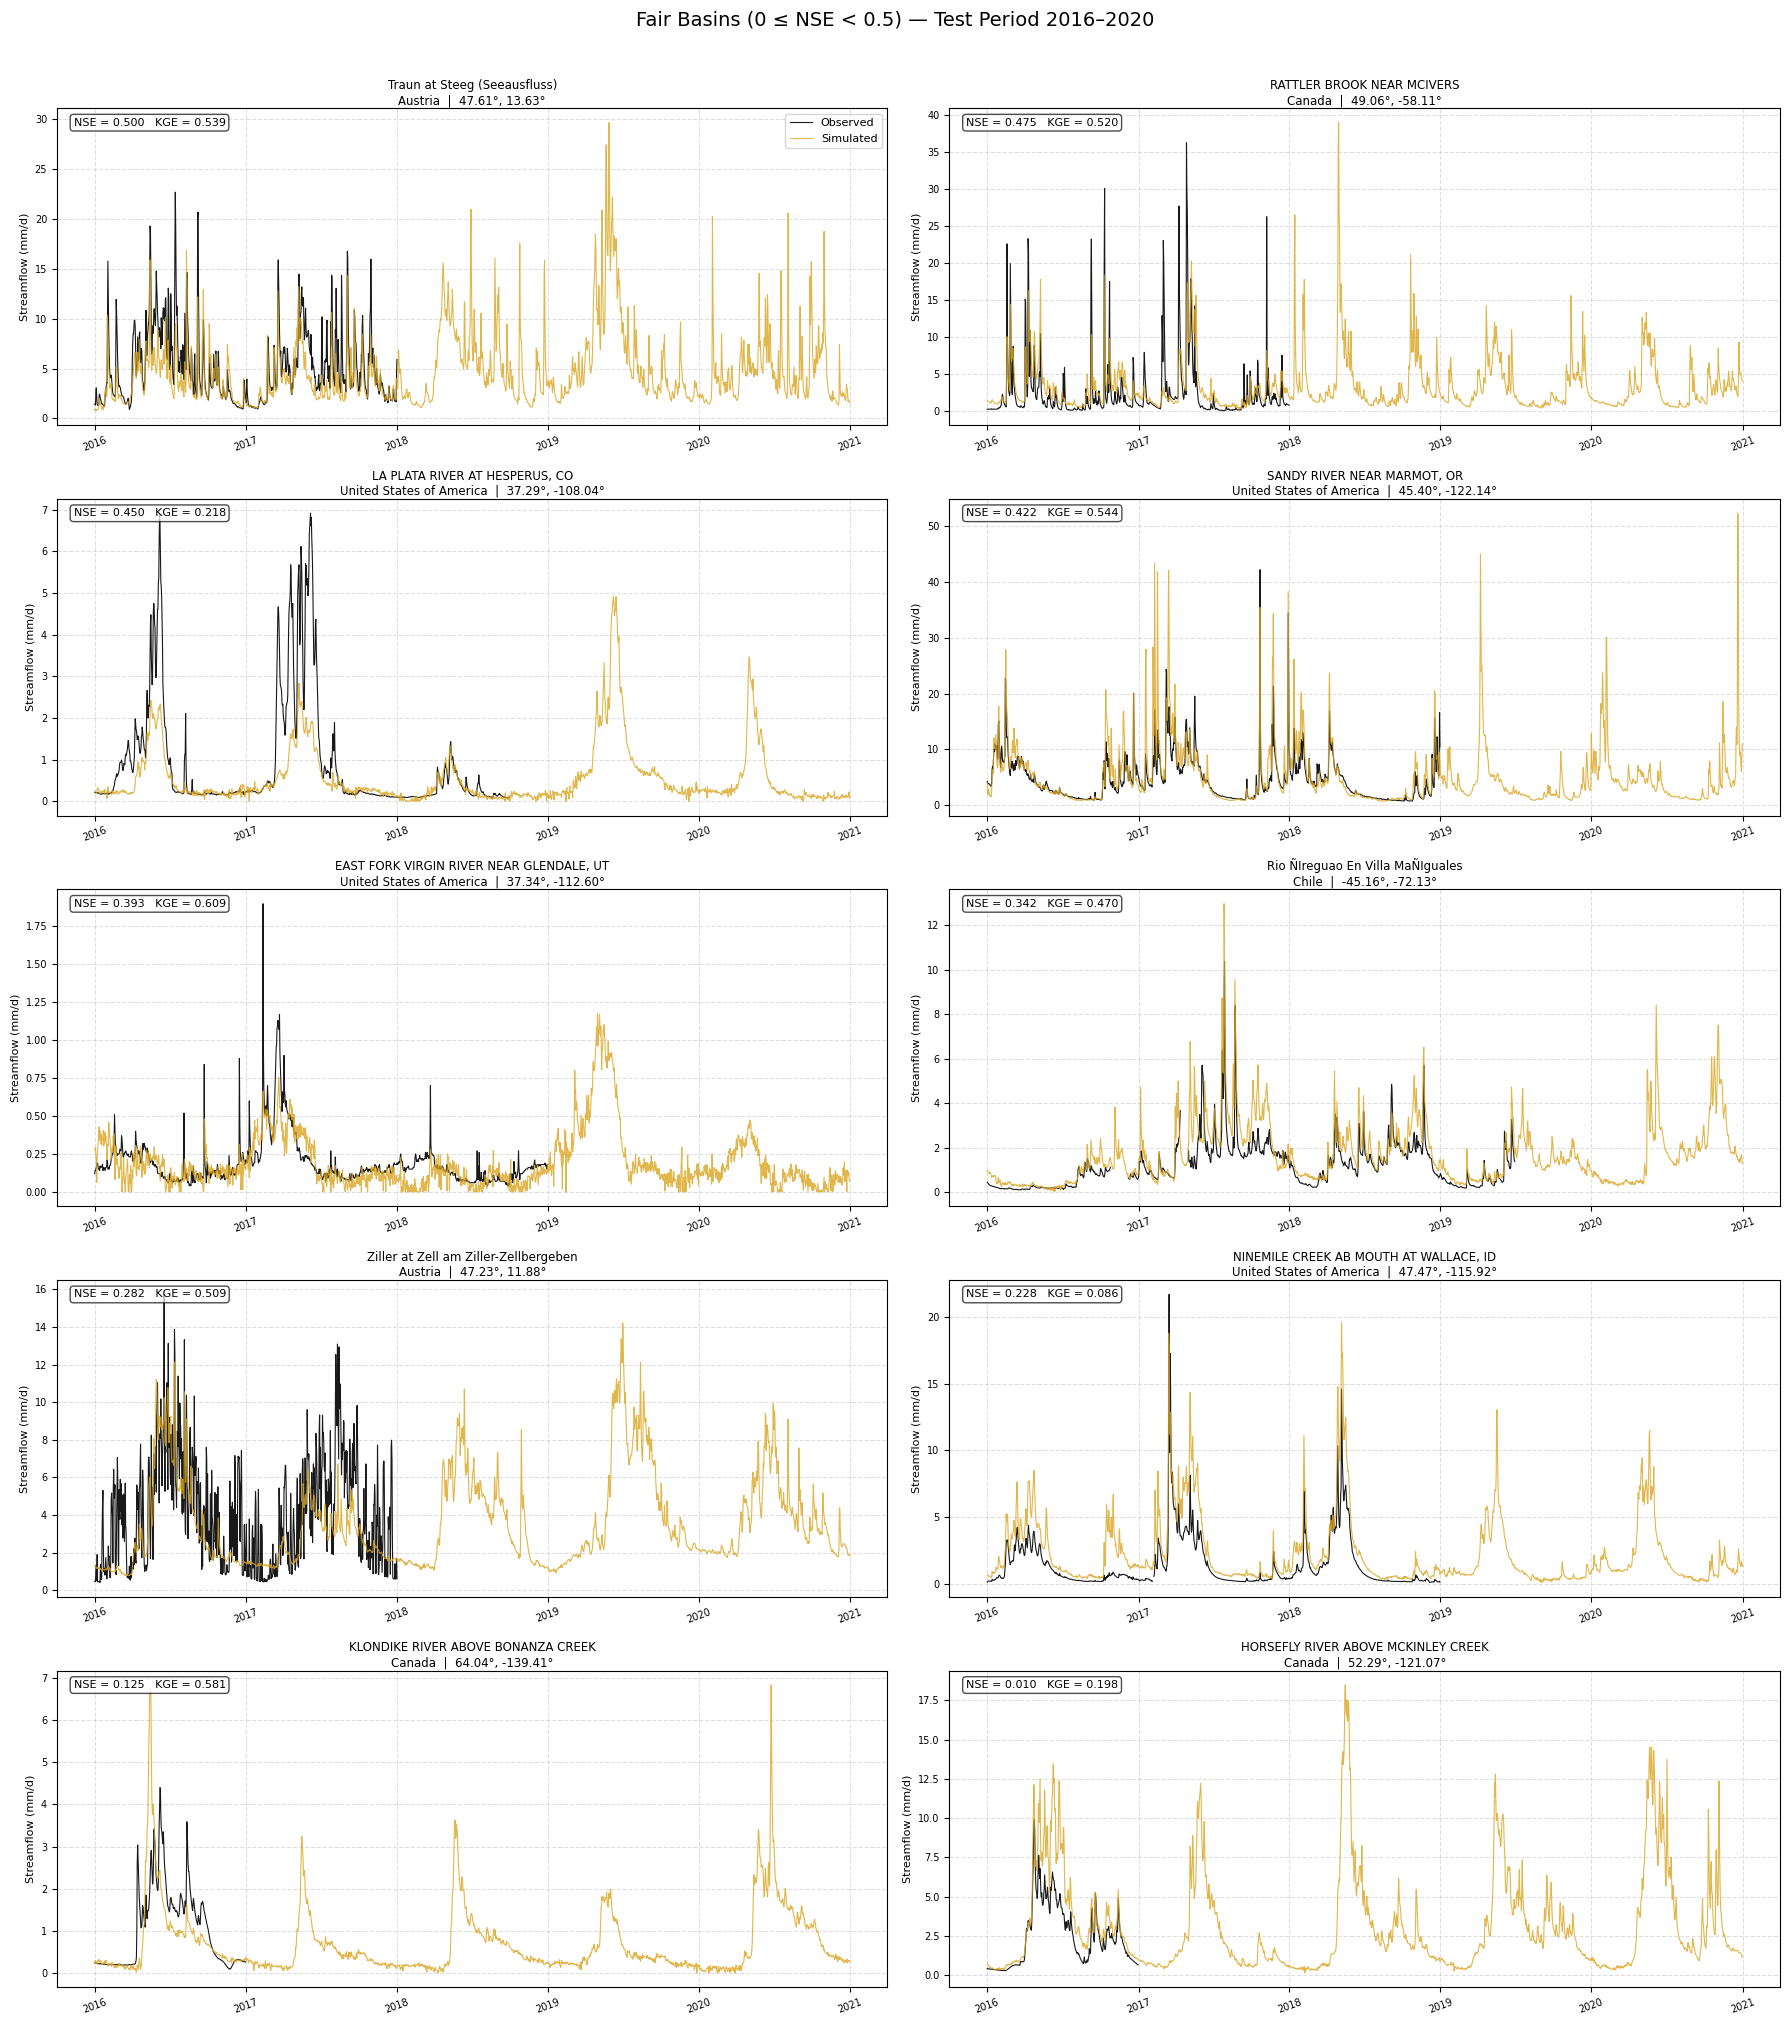

Saved: hydrographs_fair.png


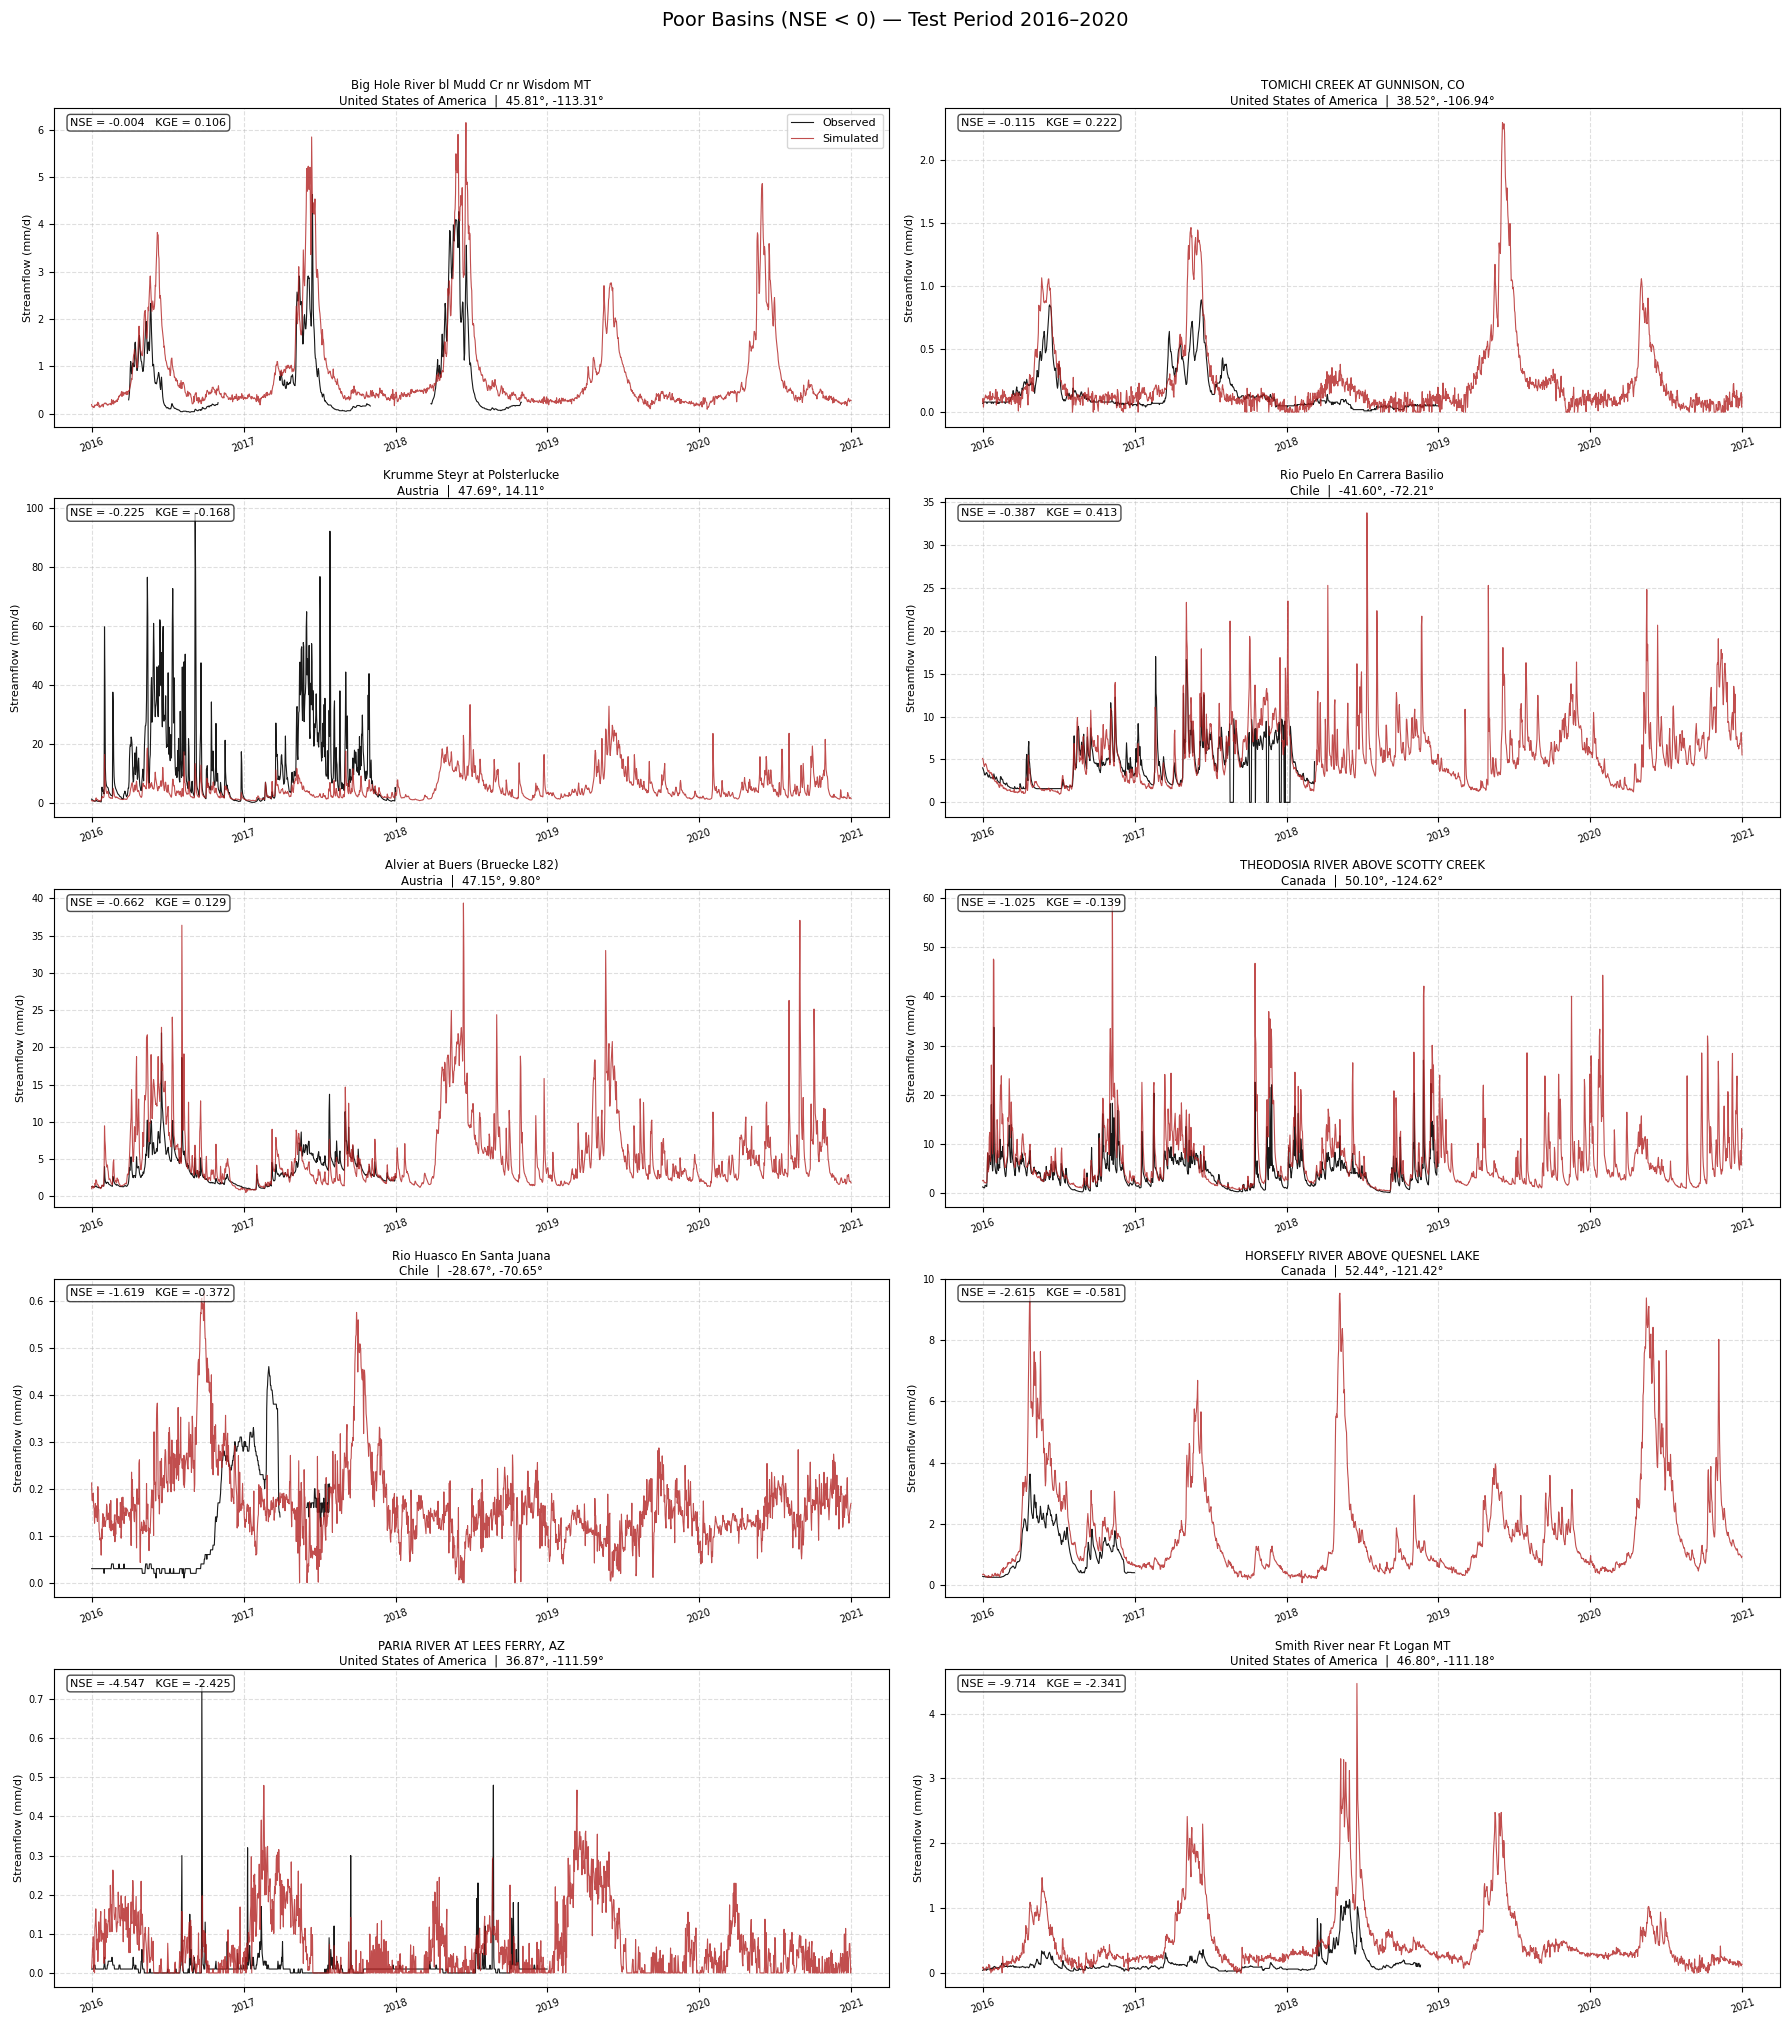

Saved: hydrographs_poor.png


In [37]:
# ── Generate hydrograph figures for each performance tier ─────────────────────
plot_hydrograph_grid(
    basin_sample = good_sample,
    test_results = test_results,
    title        = 'Good Basins (NSE ≥ 0.5) — Test Period 2016–2020',
    color_sim    = 'steelblue',
    savepath     = PROJECT_DIR / 'results' / 'hydrographs_good.png'
)

plot_hydrograph_grid(
    basin_sample = fair_sample,
    test_results = test_results,
    title        = 'Fair Basins (0 ≤ NSE < 0.5) — Test Period 2016–2020',
    color_sim    = 'goldenrod',
    savepath     = PROJECT_DIR / 'results' / 'hydrographs_fair.png'
)

plot_hydrograph_grid(
    basin_sample = poor_sample,
    test_results = test_results,
    title        = 'Poor Basins (NSE < 0) — Test Period 2016–2020',
    color_sim    = 'firebrick',
    savepath     = PROJECT_DIR / 'results' / 'hydrographs_poor.png'
)

## Interpreting the hydrographs

The 30 example hydrographs reveal distinct behavioral patterns within each
performance tier that go beyond what the aggregate metrics can show.

### Good basins (NSE ≥ 0.5)

The model excels at basins with a clear, repeating snowmelt-driven seasonal cycle.
Elk River near Natal (NSE 0.962) and Split Creek at the Mouth (NSE 0.855) show
near-perfect tracking of both the timing and magnitude of annual snowmelt peaks.
The LSTM has learned to anticipate the spring freshet and return to low summer
baseflow reliably across all five test years.

Performance remains strong even at the lower end of this tier. Mill Creek near
Walla Walla (NSE 0.500) and Come by Chance River (NSE 0.560) show correct
seasonal phasing with modest magnitude errors — the model captures *when* flow
rises and falls even if peak magnitudes are occasionally off. Notably, good
performance spans Canada, the US Rockies, and the Austrian Alps, confirming the
model has generalized across geographic regions and not just memorized one climate.

### Fair basins (0 ≤ NSE < 0.5)

Fair basins fall into two sub-patterns. The first is **timing errors**: the model
captures the seasonal shape but shifts peaks slightly early or late. This is
visible in the Ziller at Zell am Ziller (NSE 0.282, Austria) and Sandy River near
Marmot, OR (NSE 0.422), where the simulated hydrograph is clearly correlated with
observed flow but misses sharp event peaks.

The second sub-pattern is **baseflow overestimation**: Horsefly River above
McKinley Creek (NSE 0.010) shows the model predicting a persistent seasonal signal
while observed flow is much lower and flashier. This is consistent with the
attribute analysis — lower precipitation basins have less predictable runoff ratios
and the model may be drawing on patterns from wetter training basins nearby.

East Fork Virgin River near Glendale, UT (NSE 0.393) is a useful example of a
basin at the edge of our snow-dominated filter — it is semi-arid with very low
absolute flows (< 1.75 mm/d), and the model captures the general shape but with
enough volumetric error to fall into the Fair tier.

### Poor basins (NSE < 0)

Three distinct failure modes are visible in the Poor tier:

**1. Wrong hydrological regime.** Paria River at Lees Ferry, AZ (NSE −4.55) and
Smith River near Ft Logan, MT (NSE −9.71) are the clearest examples. Observed
flow is near-zero and highly episodic, but the model predicts a smooth seasonal
snowmelt cycle. These basins passed our snow fraction filter but are fundamentally
semi-arid or intermittent streams — the LSTM is applying a snow-dominated template
where it does not belong.

**2. Systematic overestimation.** Theodosia River above Scotty Creek (NSE −1.02)
and Horsefly River above Quesnel Lake (NSE −2.62) show the model consistently
predicting 2–5× more flow than observed across the entire test period. This may
reflect upstream regulation (dams or diversions) not captured in the static
attributes, or gauge records that represent only a portion of the modeled
catchment area.

**3. Data quality issues.** Rio Huasco en Santa Juana, Chile (NSE −1.62) shows
an observed record that appears to drop to near-zero for an extended period
mid-record before recovering — a pattern more consistent with a missing data gap
or gauge malfunction than a real hydrological signal. The model, having no way to
know the gauge failed, continues predicting a physically plausible seasonal cycle.

## Summary

This notebook evaluated our global snow-dominated LSTM baseline on the true
hold-out test period (2016–2020) — data the model never encountered during
training or epoch selection. Starting from a model trained on 3,297 CARAVAN
basins, we found 1,317 basins with valid test period observations and achieved:

- **Median NSE: 0.556 | Median KGE: 0.599** across Canada, Central Europe, and Chile
- **R² = 0.707, bias = 0.061 mm/d** on 1.1 million pooled daily timesteps
- **56% of basins above NSE 0.5** — competitive with published global LSTM benchmarks

Basin classification revealed that high elevation, low precipitation, and lower
snow cover persistence are the strongest predictors of poor performance. Three
distinct failure modes were identified in poorly-performing basins: regime
mismatch (semi-arid basins misclassified as snow-dominated), systematic
overestimation (likely regulated or partially-gauged catchments), and data
quality issues in the observed record.

---

## What comes next: systematic model improvement

This baseline result is a starting point, not a final answer. Before applying
this model to ungauged Alaska basins, the following improvements should be
explored systematically. The goal is to test many model configurations and
only repeat the full evaluation and classification analysis presented in this
notebook for the best-performing candidates.

### 1. Input variable optimization

Our current model uses ERA5-Land meteorological forcing (precipitation,
temperature, radiation, humidity). Several additions from the literature
have been shown to meaningfully improve LSTM performance in snow-dominated
catchments:

- **MODIS snow cover fraction** (daily, 500 m) — provides direct observational
  constraint on snow accumulation/melt that ERA5-Land at 9 km cannot capture
- **SWE estimates** from passive microwave or reanalysis products — directly
  informs the model's internal snow state
- **NDVI / EVI** — captures vegetation phenology and canopy interception,
  which modulates the snowmelt signal
- **Soil moisture indices** — improves baseflow representation during the
  recession limb
- **DEM-derived variables** (aspect, slope, hypsometric curve) — elevation
  band distributions matter for snowmelt timing in high-relief basins

Kratzert et al. (2019) showed that adding static catchment attributes as
inputs to the LSTM (the Entity-Aware LSTM, or EA-LSTM) substantially improves
generalization to ungauged basins — this is already partially implemented
through CARAVAN attributes but the attribute set can be refined.

### 2. Hyperparameter optimization

Our baseline used default neuralhydrology hyperparameters. Key hyperparameters
worth tuning systematically include:

- **Hidden size** (currently likely 256) — larger networks have more capacity
  but risk overfitting on smaller basin subsets
- **Sequence length** (lookback window) — snow-dominated basins may benefit
  from longer sequences (365+ days) to capture inter-annual SWE carryover
- **Dropout rate** — regularization is especially important when training
  on heterogeneous global data
- **Batch size and learning rate schedule** — cosine annealing with warm
  restarts (Loshchilov & Hutter, 2017) has been shown to improve convergence
  in hydrological LSTMs
- **Number of epochs with early stopping** — our fixed 30-epoch run may
  have stopped before full convergence for some basin subsets

### 3. Training data curation

Our snow-dominated filter (frac_snow > 0.3) passed 3,297 basins but as the
Poor tier hydrographs show, some of these are semi-arid or intermittent streams
that do not behave as snow-dominated in practice. More careful pre-filtering
could include:

- **Minimum mean annual streamflow threshold** — remove near-zero flow basins
  that destabilize metrics
- **Minimum record completeness** — exclude basins with > X% missing
  observations in any split window
- **Regime classification** — use a quantitative aridity/snow fraction
  2D filter rather than a single snow fraction threshold
- **Remove regulated basins** — flag basins with high `dor_pc_pva`
  (degree of regulation) from the HydroATLAS attributes, which are already
  in our merged dataframe
- **Geographic clustering** — consider whether training on basins most
  similar to Alaska (high latitude, continental, glacierized) outperforms
  training on a globally diverse set

### 4. Transfer learning strategies

For Alaska specifically, where gauged records are sparse, the literature
suggests several transfer learning approaches worth testing:

- **Fine-tuning on regional analogs** — train globally, then fine-tune on
  high-latitude Canadian/Alaskan basins with available observations
- **LSTM with pretrained encoder** — freeze early LSTM layers and retrain
  only the output head on Alaska-adjacent basins
- **Similarity-based basin selection** — identify CARAVAN basins most
  similar to each Alaska HUC10 in attribute space and weight training
  accordingly (Koster et al. approach)

### 5. Workflow for model selection

Testing 100+ configurations is realistic given CHPC GPU resources. The
recommended workflow is:

1. Define a hyperparameter and input variable search grid
2. Train each configuration using the same train/val/test split
3. **Rank by validation loss only** — do not look at test metrics during selection
4. Identify the top 5–10 configurations by validation performance
5. Run the full evaluation and classification analysis from this notebook
   on those candidates only
6. Select the final model based on test period performance and Alaska
   transferability indicators (high-elevation performance, cold basin performance)

> **Important:** Looking at test metrics during model selection introduces
> data leakage — the test period loses its status as an independent benchmark.
> All selection decisions must be made on validation performance alone.